<a href="https://colab.research.google.com/github/doyeon16/OpenCV_Python_Tutorial/blob/master/deep_learning_hand_gesture_recognition_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hand Gesture Datasets

This notebook/colab downloads hand gesture datasets and stores them as pickle files.

For more information, please take a look at: https://github.com/guillaumephd/deep_learning_hand_gesture_recognition/issues/1

Note: a (very minor) bug present in the third step described in that issue, when calling `train_test_split` function, is corrected in this notebook.

In [1]:
# ---------------------------------------------------------
# Step 1. Download hand gesture datasets
# ---------------------------------------------------------
download_shrec_17 = False
download_dhg = True
download_online_dhg = False

# --------------------------
# SHREC2017 dataset
#     http://www-rech.telecom-lille.fr/shrec2017-hand/
# --------------------------
if download_shrec_17:
  !mkdir dataset_shrec2017
  !wget http://www-rech.telecom-lille.fr/shrec2017-hand/HandGestureDataset_SHREC2017.tar.gz -O SHREC2017.tar.gz
  !tar -xzf SHREC2017.tar.gz -C dataset_shrec2017
# --------------------------
# DHG14/28 dataset
#     http://www-rech.telecom-lille.fr/DHGdataset/
# --------------------------
# Note: you should register on http://www-rech.telecom-lille.fr/DHGdataset/ before downloading the dataset
if download_dhg:
  !mkdir dataset_dhg1428
  !wget http://www-rech.telecom-lille.fr/DHGdataset/DHG2016.zip
  !unzip DHG2016.zip -d dataset_dhg1428
# --------------------------
# Online DHG dataset
#     http://www-rech.telecom-lille.fr/shrec2017-hand/
# --------------------------
if download_online_dhg:
  !mkdir dataset_onlinedhg
  !wget http://www-rech.telecom-lille.fr/shrec2017-hand/OnlineDHG.zip
  !unzip OnlineDHG.zip -d dataset_onlinedhg

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: dataset_dhg1428/gesture_9/finger_2/subject_18/essai_3/depth_2.png  
  inflating: dataset_dhg1428/gesture_9/finger_2/subject_18/essai_3/depth_20.png  
  inflating: dataset_dhg1428/gesture_9/finger_2/subject_18/essai_3/depth_21.png  
  inflating: dataset_dhg1428/gesture_9/finger_2/subject_18/essai_3/depth_22.png  
  inflating: dataset_dhg1428/gesture_9/finger_2/subject_18/essai_3/depth_23.png  
  inflating: dataset_dhg1428/gesture_9/finger_2/subject_18/essai_3/depth_24.png  
  inflating: dataset_dhg1428/gesture_9/finger_2/subject_18/essai_3/depth_25.png  
  inflating: dataset_dhg1428/gesture_9/finger_2/subject_18/essai_3/depth_26.png  
  inflating: dataset_dhg1428/gesture_9/finger_2/subject_18/essai_3/depth_27.png  
  inflating: dataset_dhg1428/gesture_9/finger_2/subject_18/essai_3/depth_28.png  
  inflating: dataset_dhg1428/gesture_9/finger_2/subject_18/essai_3/depth_29.png  
  inflating: dataset_dhg1428/gesture_9/finger_2/subject_18/essa

In [0]:
# ---------------------------------------------------------
# Step 2. Utils
# ---------------------------------------------------------
import glob
import numpy
import pickle
from scipy import ndimage as ndimage
from sklearn.model_selection import train_test_split


def resize_gestures(input_gestures, final_length=100):
    """
    Resize the time series by interpolating them to the same length

    Input:
        - input_gestures: list of numpy.ndarray tensors.
              Each tensor represents a single gesture.
              Gestures can have variable durations.
              Each tensor has a shape: (duration, channels)
              where duration is the duration of the individual gesture
                    channels = 44 = 2 * 22 if recorded in 2D and
                    channels = 66 = 3 * 22 if recorded in 3D 
    Output:
        - output_gestures: one numpy.ndarray tensor.
              The output tensor has a shape: (records, final_length, channels)
              where records = len(input_gestures)
                   final_length is the common duration of all gestures
                   channels is the same as above 
    """
    # please use python3. if you still use python2, important note: redefine the classic division operator / by importing it from the __future__ module
    output_gestures = numpy.array([numpy.array([ndimage.zoom(x_i.T[j], final_length / len(x_i), mode='reflect') for j in range(numpy.size(x_i, 1))]).T for x_i in input_gestures])
    return output_gestures


def load_gestures(dataset='dhg', root='/content/dataset_dhg1428', version_x='3D', version_y='both', resize_gesture_to_length=100):
    """
    Get the 3D or 2D pose gestures sequences, and their associated labels.

    Ouput:
        - a tuple of (gestures, labels) or (gestures, labels_14, labels_28)
              where gestures is either a numpy.ndarray tensor or
                                       a list of numpy.ndarray tensors,
                                       depending on if the gestures have been resized or not.
              Each tensor represents a single gesture.
              Gestures can have variable durations.
              Each tensor has a shape: (duration, channels) where channels is either 44 (= 2 * 22) or 66 (=3 * 22)
    """

    # SHREC 2017 (on Google Colab):
    # root = '/content/dataset_shrec2017/HandGestureDataset_SHREC2017'
    # DHG 14/28 (on Google Colab):
    # root = '/content/dataset_dhg1428'
    if dataset == 'dhg':
      assert 'dataset_dhg' in root
    if dataset == 'shrec':
      assert 'dataset_shrec' in root
    
    if version_x == '3D':
        if dataset == 'dhg':
            pattern = root + '/gesture_*/finger_*/subject_*/essai_*/skeleton_world.txt'
        elif dataset == 'shrec':
            pattern = root + '/gesture_*/finger_*/subject_*/essai_*/skeletons_world.txt'
    else:
        if dataset == 'dhg':
            pattern = root + '/gesture_*/finger_*/subject_*/essai_*/skeleton_image.txt'
        elif dataset == 'shrec':
            pattern = root + '/gesture_*/finger_*/subject_*/essai_*/skeletons_image.txt'

    gestures_filenames = sorted(glob.glob(pattern))
    gestures = [numpy.genfromtxt(f) for f in gestures_filenames]
    if resize_gesture_to_length is not None:
        gestures = resize_gestures(gestures, final_length=resize_gesture_to_length)

    labels_14 = [int(filename.split('/')[-5].split('_')[1]) for filename in gestures_filenames]
    labels_28 = [int(filename.split('/')[-4].split('_')[1]) for filename in gestures_filenames]
    labels_28 = [labels_14[idx_gesture] if n_fingers_used == 1 else 14 + labels_14[idx_gesture] for idx_gesture, n_fingers_used in enumerate(labels_28)]

    if version_y == '14' or version_y == 14:
        return gestures, labels_14
    elif version_y == '28' or version_y == 28:
        return gestures, labels_28
    elif version_y == 'both':
        return gestures, labels_14, labels_28


def write_data(data, filepath):
    """Save the dataset to a file. Note: data is a dict with keys 'x_train', ..."""
    with open(filepath, 'wb') as output_file:
        pickle.dump(data, output_file)


def load_data(filepath='./shrec_data.pckl'):
    """
    Returns hand gesture sequences (X) and their associated labels (Y).
    Each sequence has two different labels.
    The first label  Y describes the gesture class out of 14 possible gestures (e.g. swiping your hand to the right).
    The second label Y describes the gesture class out of 28 possible gestures (e.g. swiping your hand to the right with your index pointed, or not pointed).
    """
    file = open(filepath, 'rb')
    data = pickle.load(file, encoding='latin1')  # <<---- change to 'latin1' to 'utf8' if the data does not load
    file.close()
    #return data['x_train'], data['x_test'], data['y_train_14'], data['y_train_28'], data['y_test_14'], data['y_test_28']
    return data['x_train'], data['x_test'], data['y_train_14'],  data['y_test_14']

In [0]:
# ---------------------------------------------------------
# Step 3. Save the dataset(s) you need
# ---------------------------------------------------------
# Example: 3D version of the SHREC17 and DHG gesture datasets, with gestures resized to 100 timesteps
gestures, labels_14 = load_gestures(dataset='dhg',
                                               root='/content/dataset_dhg1428',
                                               version_x='3D',
                                               version_y='14',
                                               resize_gesture_to_length=100)
# Split the dataset into train and test sets if you want:
#x_train, x_test, y_train_14, y_train_28, y_test_14, y_test_28 = train_test_split(gestures, labels_14, labels_28, test_size=0.30)
x_train, x_test, y_train_14, y_test_14 = train_test_split(gestures, labels_14, test_size=0.30)

# Save the dataset
data = {
    'x_train': x_train,
    'x_test': x_test,
    'y_train_14': y_train_14,
    #'y_train_28': y_train_28,
    'y_test_14': y_test_14,
    #'y_test_28': y_test_28
}
write_data(data, filepath='dhg_data.pckl')

In [0]:
# ---------------------------------------------------------
# Step 4. Optional: copy to google drive, if you're in a Google Colab
# ---------------------------------------------------------
try:

  # Connect Google Colab instance to Google Drive
  from google.colab import drive
  drive.mount('/gdrive')

  # Save your dataset on Google Drive
  !cp dhg_data.pckl /gdrive/My\ Drive/dhg_data.pckl

  # Load your dataset from Google Drive
  # !cp /gdrive/My\ Drive/dhg_data.pckl dhg_data.pckl

except:
  print("You're not in a Google Colab!")

You're not in a Google Colab!


In [0]:
# ---------------------------------------------------------
# Step 5. Use the dataset(s)
# ---------------------------------------------------------
x_train, x_test, y_train_14, y_test_14= load_data('dhg_data.pckl')

In [5]:
print(y_train_14.__len__())
print(y_test_14.__len__())

1960
840


In [6]:
%tensorflow_version 2

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [0]:
force_use_cpu = False

if force_use_cpu:
    import os
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
    os.environ["CUDA_VISIBLE_DEVICES"] = ""
    
    from tensorflow.keras import backend as K
    print('There should not be a GPU in the following list:', K.tensorflow_backend._get_available_gpus())

In [0]:
import numpy
import tensorflow
import tensorflow.keras as keras
import pickle
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Conv1D, AveragePooling1D, Dropout, Flatten, Lambda, Dense
from tensorflow.keras.layers import concatenate
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt

In [0]:
# model
dropout_probability = 0.2
duration = 100
n_classes = 14
n_channels = 66  # usually  n_channels = 2 * n_joints  or  n_channels = 3 * n_joints

In [0]:
def create_model(n_classes, duration, n_channels, dropout_probability=0.2):
    # Define model, using functional API
    model_input = Input(shape=(duration, n_channels))

    # slice into channels
    channel_inputs = Lambda(lambda x: tensorflow.split(x, num_or_size_splits=n_channels, axis=-1))(model_input)

    features = []
    for channel in range(n_channels):
        channel_input = channel_inputs[channel]
        # high branch
        high = Conv1D(filters=8, kernel_size=7, padding='same', activation='relu', input_shape=(100, 1))(channel_input)
        high = AveragePooling1D(pool_size=2)(high)
        high = Conv1D(filters=4, kernel_size=7, padding='same', activation='relu')(high)
        high = AveragePooling1D(pool_size=2)(high)
        high = Conv1D(filters=4, kernel_size=7, padding='same', activation='relu')(high)
        high = Dropout(dropout_probability)(high)
        high = AveragePooling1D(pool_size=2)(high)
        # low branch
        low = Conv1D(filters=8, kernel_size=3, padding='same', activation='relu', input_shape=(100, 1))(channel_input)
        low = AveragePooling1D(pool_size=2)(low)
        low = Conv1D(filters=4, kernel_size=3, padding='same', activation='relu')(low)
        low = AveragePooling1D(pool_size=2)(low)
        low = Conv1D(filters=4, kernel_size=3, padding='same', activation='relu')(low)
        low = Dropout(dropout_probability)(low)
        low = AveragePooling1D(pool_size=2)(low)
        # pooling branch
        ap_residual = AveragePooling1D(pool_size=2, input_shape=(100, 1))(channel_input)
        ap_residual = AveragePooling1D(pool_size=2)(ap_residual)
        ap_residual = AveragePooling1D(pool_size=2)(ap_residual)
        # channel output
        channel_output = concatenate([high, low, ap_residual])
        features.append(channel_output)

    features = concatenate(features)
    features = Flatten()(features)
    features = Dense(units=1936, activation='relu')(features)

    model_output = Dense(units=n_classes, activation='softmax')(features)

    model = Model(inputs=[model_input], outputs=[model_output])
    return model

In [0]:
model = create_model(n_classes=n_classes, duration=duration, n_channels=n_channels, dropout_probability=dropout_probability)

In [0]:
model.summary()

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.322313 to fit



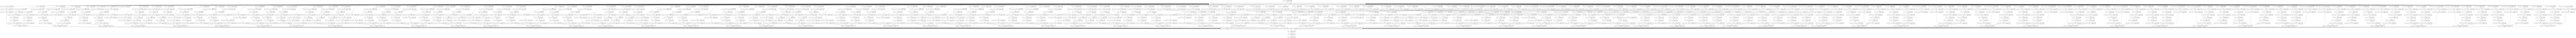

In [13]:
plot_model(model, to_file='model.png', show_shapes=True)

In [14]:
# We load a gesture dataset:
#
#   x.shape should be (dataset_size, duration, channel)
#   y.shape should be (dataset_size, 1)


# If you want to use the DHG dataset, go to: https://colab.research.google.com/drive/1ggYG1XRpJ50gVgJqT_uoI257bspNogHj
use_dhg_dataset = True

if use_dhg_dataset:

    try:
        # Connect Google Colab instance to Google Drive
        from google.colab import drive
        drive.mount('/gdrive')
        # Load the dataset (you already have created in the other notebook) from Google Drive
        !cp /gdrive/My\ Drive/dhg_data.pckl dhg_data.pckl
    except:
        print("You're not in a Google Colab!")


    #x_train, x_test, y_train_14, y_test_14= load_data('dhg_data.pckl')
    print(y_train_14.__len__())
    print(y_test_14.__len__())
    y_train_14, y_test_14 = numpy.array(y_train_14), numpy.array(y_test_14)
    #y_train_28, y_test_28 = numpy.array(y_train_28), numpy.array(y_test_28)
    if n_classes == 14:
        y_train = y_train_14
        y_test = y_test_14
    elif n_classes == 28:
        y_train = y_train_28
        y_test = y_test_28

else:
    # Let's create fake data, with shape: (dataset_size, duration, channel)
    x_train = numpy.random.randn(2000, duration, n_channels)
    y_train = numpy.random.random_integers(n_classes, size=2000)

    x_test = numpy.random.randn(1000, duration, n_channels)
    y_test = numpy.random.random_integers(n_classes, size=1000)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive
1960
840


In [15]:
print(y_train.shape)
print(y_test.shape)

(1960,)
(840,)


In [0]:
# Ensure the label values are between 0 and n_classes-1
if y_train.min() > 0:
  y_train = y_train - 1
if y_test.min() > 0:
  y_test = y_test - 1

# Transform the labels to one-hot encoding for the cross-entropy loss
y_train = to_categorical(y_train, num_classes=n_classes)
y_test = to_categorical(y_test, num_classes=n_classes)

In [0]:
# Training: Optimizer's Learning Rate
learning_rate = 0.001

# We use Adam to optimize a multi-class classification task
optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8)
loss = 'categorical_crossentropy'
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [18]:
# Start the training

# ...with an existing validation set:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=32)

# ...or, if there is no validation set:
# history = model.fit(x_train, y_train, validation_split=0.33, epochs=100, batch_size=32)

Epoch 1/100
62/62 [==============================] - 43s 695ms/step - loss: 2.7676 - accuracy: 0.1122 - val_loss: 2.5191 - val_accuracy: 0.2048
Epoch 2/100
62/62 [==============================] - 38s 610ms/step - loss: 2.2709 - accuracy: 0.2673 - val_loss: 2.0002 - val_accuracy: 0.3298
Epoch 3/100
62/62 [==============================] - 38s 608ms/step - loss: 1.7534 - accuracy: 0.4255 - val_loss: 1.5725 - val_accuracy: 0.5202
Epoch 4/100
62/62 [==============================] - 39s 629ms/step - loss: 1.4509 - accuracy: 0.5270 - val_loss: 1.3659 - val_accuracy: 0.5881
Epoch 5/100
62/62 [==============================] - 37s 602ms/step - loss: 1.2888 - accuracy: 0.5735 - val_loss: 1.2107 - val_accuracy: 0.6071
Epoch 6/100
62/62 [==============================] - 36s 574ms/step - loss: 1.1677 - accuracy: 0.6138 - val_loss: 1.2099 - val_accuracy: 0.5952
Epoch 7/100
62/62 [==============================] - 36s 574ms/step - loss: 1.0945 - accuracy: 0.6398 - val_loss: 1.0126 - val_accuracy:

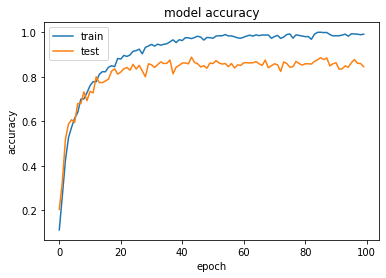

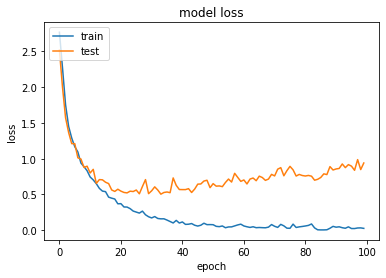

In [19]:
# plot everything
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [20]:
_, train_accuracy = model.evaluate(x_train, y_train)
_, test_accuracy = model.evaluate(x_test, y_test)

27/27 [==============================] - 4s 157ms/step - loss: 0.9401 - accuracy: 0.8452


In [21]:
print('Accuracy on train set: {:.2f}%'.format(100 * train_accuracy))
print('Accuracy on test set: {:.2f}%'.format(100 * test_accuracy))

Accuracy on train set: 99.59%
Accuracy on test set: 84.52%
